In [ ]:
import requests
import json
import time
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def rumble(line, cell=None):
    if cell is None:
        data = line
    else:
        data = cell

    start = time.time()                                                         
    response = json.loads(requests.post(server, data=data).text)                   
    end = time.time()                                                              
    print("Took: %s ms" % (end - start))

    if 'warning' in response:
        print(json.dumps(response['warning']))
    if 'values' in response:
        for e in response['values']:
            print(json.dumps(e))
    elif 'error-message' in response:
        return print(response['error-message'])
    else:
        return print(response)

In [ ]:
server='http://localhost:9090/jsoniq'

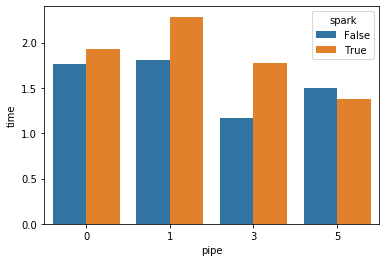

In [47]:
#Rumble: 1.759, 1.813, 1.169, 1.504
#Spark: 1.933, 2.286, 1.774, 1.377

import pandas as pd
import seaborn as sns

df = pd.DataFrame(columns = ['time','pipe','spark'])
df = df.append({'time': 1.759, 'pipe': 0, 'spark': False}, ignore_index=True)
df = df.append({'time': 1.813, 'pipe': 1, 'spark': False}, ignore_index=True)
df = df.append({'time': 1.169, 'pipe': 3, 'spark': False}, ignore_index=True)
df = df.append({'time': 1.504, 'pipe': 5, 'spark': False}, ignore_index=True)

df = df.append({'time': 1.933, 'pipe': 0, 'spark': True}, ignore_index=True)
df = df.append({'time': 2.286, 'pipe': 1, 'spark': True}, ignore_index=True)
df = df.append({'time': 1.774, 'pipe': 3, 'spark': True}, ignore_index=True)
df = df.append({'time': 1.377, 'pipe': 5, 'spark': True}, ignore_index=True)

ax = sns.barplot(x="pipe", y="time", hue="spark", data=df)



## Train model

### Pipe_0

In [50]:
%%rumble
let $training-data := csv-file("/Users/david/Projects/pipelines/data/uci.csv", {header: true, inferSchema: true})
let $test-data := csv-file("/Users/david/Projects/pipelines/data/uci.csv", {header: true, inferSchema: true})
let $vector-assembler := get-transformer("VectorAssembler", {"inputCols" : [ "col_0", "col_1", "col_2", "col_3", "col_4", "col_5", "col_6", "col_7", "col_8", "col_9", "col_10", "col_11", "col_12", "col_13" ], "outputCol" : "features"})
let $vector-assembler_2 := get-transformer("VectorAssembler", {"inputCols" : ["features"], "outputCol" : "transformedFeatures"})
let $logisticregression := get-estimator("LogisticRegression", {"featuresCol": "transformedFeatures"})
let $pipeline := get-estimator("Pipeline", {"stages": [$vector-assembler, $vector-assembler_2, $logisticregression]})
let $pip := $pipeline($training-data, {})
return $pip($test-data, {})

Took: 3.3430349826812744 ms
"Warning! The output sequence contains 1592 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"id": 0, "label": 1, "col_0": 50, "col_1": 0, "col_2": 23686, "col_3": 1, "col_4": 10, "col_5": 0, "col_6": 8, "col_7": 4, "col_8": 0, "col_9": 0, "col_10": 0, "col_11": 0, "col_12": 35, "col_13": 0, "features": {"0": 50, "2": 23686, "3": 1, "4": 10, "6": 8, "7": 4, "12": 35}, "transformedFeatures": {"0": 50, "2": 23686, "3": 1, "4": 10, "6": 8, "7": 4, "12": 35}, "rawPrediction": [-0.6111866311258822, 0.6111866311258822], "probability": [0.3517885588601332, 0.6482114411398667], "prediction": 1}
{"id": 1, "label": 1, "col_0": 47, "col_1": 0, "col_2": 158451, "col_3": 10, "col_4": 14, "col_5": 0, "col_6": 5, "col_7": 0, "col_8": 0, "col_9": 0, "col_10": 0, "col_11": 0, "col_12": 2, "col_13": 0, "features": {"0": 47, "2": 158451, "3": 10, "4": 14, "6": 5, "12": 

### Pipe_1

In [35]:
%%rumble
let $total := 6042135 
let $training-data := parquet-file("/Users/david/Projects/rumble_testbed/criteo.kaggle2014.test.parquet")
let $test-data := parquet-file("/Users/david/Projects/rumble_testbed/criteo.kaggle2014.test.parquet")
let $scaler := get-estimator("MaxAbsScaler", {"inputCol": "features", "outputCol": "transformedFeatures"})
let $logisticregression := get-estimator("LogisticRegression", {"featuresCol": "transformedFeatures"})
let $pipeline := get-estimator("Pipeline", {"stages": [ $scaler, $logisticregression]})
let $pip := $pipeline($training-data, {})
let $prediction := $pip($test-data, {})
return count(for $i in $prediction
    where $i.label eq $i.prediction
    return $i
) div $total # calculates accuracy

Took: 1.8132078647613525 ms
"Warning! The output sequence contains 1592 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"id": 0, "label": 1, "col_0": 50, "col_1": 0, "col_2": 23686, "col_3": 1, "col_4": 10, "col_5": 0, "col_6": 8, "col_7": 4, "col_8": 0, "col_9": 0, "col_10": 0, "col_11": 0, "col_12": 35, "col_13": 0, "features": {"0": 50, "2": 23686, "3": 1, "4": 10, "6": 8, "7": 4, "12": 35}, "transformedFeatures": {"0": 0.5555555555555556, "2": 0.036559126507604775, "3": 0.06666666666666667, "4": 0.625, "6": 0.6153846153846154, "7": 0.8, "12": 0.3535353535353536}, "rawPrediction": [-0.6111866310519813, 0.6111866310519813], "probability": [0.3517885588769851, 0.6482114411230149], "prediction": 1}
{"id": 1, "label": 1, "col_0": 47, "col_1": 0, "col_2": 158451, "col_3": 10, "col_4": 14, "col_5": 0, "col_6": 5, "col_7": 0, "col_8": 0, "col_9": 0, "col_10": 0, "col_11": 0, "col_1

### Pipe_3

In [36]:
%%rumble
let $training-data := parquet-file("/Users/david/Projects/pipelines/data/uci.parquet")
let $test-data := parquet-file("/Users/david/Projects/pipelines/data/uci_test.parquet")
let $vector-assembler := get-transformer("VectorAssembler", {"inputCols" : [ "col_0", "col_1", "col_2", "col_3", "col_4", "col_5", "col_6", "col_7", "col_8", "col_9", "col_10", "col_11", "col_12", "col_13" ], "outputCol" : "features"})
let $pca := get-estimator("PCA", {"inputCol": "features", "outputCol": "transformedFeatures", "k": 2})
let $logisticregression := get-estimator("LogisticRegression", {"featuresCol": "transformedFeatures"})
let $pipeline := get-estimator("Pipeline", {"stages": [$vector-assembler, $pca, $logisticregression]})
let $pip := $pipeline($training-data, {})
return $pip($test-data, {})

Took: 1.1692719459533691 ms
"Warning! The output sequence contains 1592 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"id": 0, "label": 1, "col_0": 50, "col_1": 0, "col_2": 23686, "col_3": 1, "col_4": 10, "col_5": 0, "col_6": 8, "col_7": 4, "col_8": 0, "col_9": 0, "col_10": 0, "col_11": 0, "col_12": 35, "col_13": 0, "features": {"0": 50, "2": 23686, "3": 1, "4": 10, "6": 8, "7": 4, "12": 35}, "transformedFeatures": [23685.99872709563, 3.7078220427449873], "rawPrediction": [0.8833110819978157, -0.8833110819978157], "probability": [0.7075078884579343, 0.29249211154206567], "prediction": 0}
{"id": 1, "label": 1, "col_0": 47, "col_1": 0, "col_2": 158451, "col_3": 10, "col_4": 14, "col_5": 0, "col_6": 5, "col_7": 0, "col_8": 0, "col_9": 0, "col_10": 0, "col_11": 0, "col_12": 2, "col_13": 0, "features": {"0": 47, "2": 158451, "3": 10, "4": 14, "6": 5, "12": 2}, "transformedFeatures

### Pipe_5

In [37]:
%%rumble
let $training-data := parquet-file("/Users/david/Projects/pipelines/data/uci.parquet")
let $test-data := parquet-file("/Users/david/Projects/pipelines/data/uci_test.parquet")
let $vector-assembler := get-transformer("VectorAssembler", {"inputCols" : [ "col_0", "col_1", "col_2", "col_3", "col_4", "col_5", "col_6", "col_7", "col_8", "col_9", "col_10", "col_11", "col_12", "col_13" ], "outputCol" : "features"})
let $pca := get-estimator("PCA", {"inputCol": "features", "outputCol": "pca_1_output", "k": 2})
let $pca2 := get-estimator("PCA", {"inputCol": "features", "outputCol": "pca_2_output", "k": 3})
let $vector-assembler_2 := get-transformer("VectorAssembler", {"inputCols" : ["pca_1_output","pca_2_output"], "outputCol" : "transformedFeatures"})
let $logisticregression := get-estimator("LogisticRegression", {"featuresCol": "transformedFeatures"})
let $pipeline := get-estimator("Pipeline", {"stages": [$vector-assembler, $pca, $pca2, $vector-assembler_2, $logisticregression]})
let $pip := $pipeline($training-data, {})
return $pip($test-data, {})

Took: 1.50416898727417 ms
"Warning! The output sequence contains 1592 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"id": 0, "label": 1, "col_0": 50, "col_1": 0, "col_2": 23686, "col_3": 1, "col_4": 10, "col_5": 0, "col_6": 8, "col_7": 4, "col_8": 0, "col_9": 0, "col_10": 0, "col_11": 0, "col_12": 35, "col_13": 0, "features": {"0": 50, "2": 23686, "3": 1, "4": 10, "6": 8, "7": 4, "12": 35}, "pca_1_output": [23685.99872709563, 3.7078220427449873], "pca_2_output": [23685.99872709563, 3.7078220427449873, -5.045836964846752], "transformedFeatures": [23685.99872709563, 3.7078220427449873, 23685.99872709563, 3.7078220427449873, -5.045836964846752], "rawPrediction": [1.0110550164997696, -1.0110550164997696], "probability": [0.7332265669016048, 0.2667734330983952], "prediction": 0}
{"id": 1, "label": 1, "col_0": 47, "col_1": 0, "col_2": 158451, "col_3": 10, "col_4": 14, "col_5": 0, "